In [1]:
import numpy as np
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt

from random_feature_gp import (generate_rff,
    bayesian_linear_model_loss,
    bayesian_censored_model_loss,
    fit_laplace_posterior,
    laplace_predictive)

In [5]:
MAX_VALUE = 0.0

def noise_free_target(x):
    y = (x-2)*10
    return y * torch.sin(y) / 2

def oracle(x):
    return torch.clamp_max(noise_free_target(x) + torch.randn(x.shape) , 0.0)

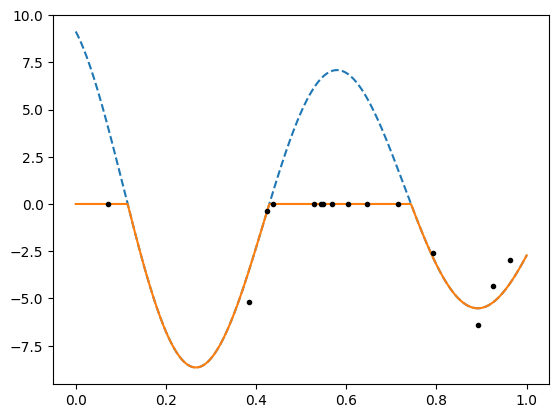

In [6]:
N_init = 15
np.random.seed(0)
x = torch.FloatTensor(np.random.rand(N_init))
torch.sort(x)
y = oracle(x)

features = generate_rff(1, M=100)

domain = torch.linspace(0, 1, 500)
plt.plot(domain, noise_free_target(domain), '--');
plt.plot(domain, torch.clamp_max(noise_free_target(domain), 0), '-');
plt.plot(x, y, 'k.')

In [7]:
def fit_linear_model():
    log_lengthscale = torch.tensor(-1.0).requires_grad_(True)
    # log_scale = torch.tensor(0.0).requires_grad_(True)
    log_noise = torch.tensor(0.0).requires_grad_(True)

    phi = features(x[:,None], log_lengthscale.exp())
    w_hat = torch.zeros(phi.shape[-1]).requires_grad_(True)


    # opt = torch.optim.Adagrad([w_hat, log_lengthscale, log_scale, log_noise], lr=1.0)
    opt = torch.optim.Adagrad([w_hat, log_lengthscale, log_noise], lr=0.1)
    tmp = []
    for i in range(20000):
        opt.zero_grad();
        phi = features(x[:,None], log_lengthscale.exp())
        loss = bayesian_linear_model_loss(w_hat, phi, y, log_noise.exp())
        loss.backward()
        opt.step()
        tmp.append(loss.item())

    plt.plot(tmp[200:]);

    with torch.no_grad():
        print("lengthscale: %0.4f\nnoise: %0.4f" % (log_lengthscale.exp(), log_noise.exp()))

    print("LOSS:", loss.item())

    return w_hat, log_lengthscale.exp().item(), log_noise.exp().item()

lengthscale: 0.2348
noise: 1.1066
LOSS: 115.11608123779297


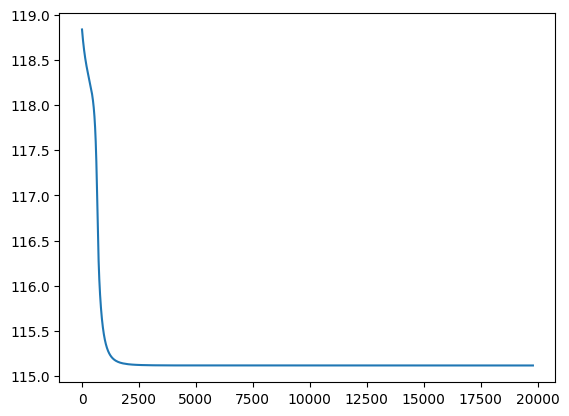

In [8]:
# Fit mode
w_hat_linear, lengthscale_linear, noise_linear = fit_linear_model()

# Laplace approximation to posterior variance
phi = features(x[:,None], lengthscale_linear)
H_linear = fit_laplace_posterior(w_hat_linear,
                                 lambda w: bayesian_linear_model_loss(w, phi, y, noise_linear))


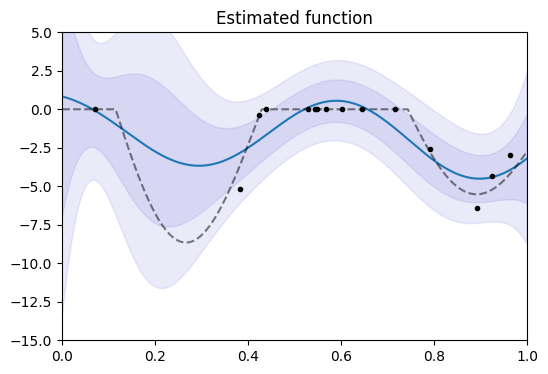

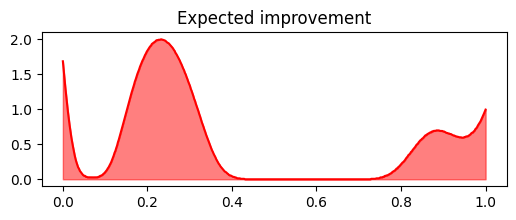

In [9]:
def plot_result(w_hat, H, lengthscale, noise, censored=False):

    phi_plot = features(domain[:,None], lengthscale)
    pred = laplace_predictive(phi_plot, w_hat, H)

    N_samples = 1000
#     pred_samples = pred.sample((N_samples,)) + dist.Normal(0, noise).sample((N_samples,domain.shape[0]))
    breakpoints = torch.linspace(0, 1, N_samples+1)[:-1]
    breakpoints = breakpoints + breakpoints[1] * torch.rand_like(breakpoints)
    pred_samples = dist.Normal(pred.loc, pred.scale + noise).icdf(breakpoints[:,None])

    if censored:
        c_pred = pred_samples > MAX_VALUE
        pred_samples[c_pred] = MAX_VALUE

    pred_median = np.median(pred_samples, axis=0)
    pred_quantiles = np.quantile(pred_samples, [0.025, 0.15, 0.85, 0.975], axis=0)

    plt.figure(figsize=(6, 4))
    plt.plot(domain, pred_median)

    plt.fill_between(domain, pred_quantiles[0], pred_quantiles[-1], alpha=0.1, color='#33c');
    plt.fill_between(domain, pred_quantiles[1], pred_quantiles[-2], alpha=0.1, color='#33c');

    plt.plot(x, y, 'k.');
    plt.plot(domain, noise_free_target(domain).clamp_max(MAX_VALUE), 'k--', alpha=0.5);
    plt.xlim(0, 1);
    plt.ylim(-15, 5);
    plt.title("Estimated function")

    plt.figure(figsize=(6, 2))
    plt.title("Expected improvement")
    EI =  -(pred_samples*(pred_samples < y.min()).float()).mean(0)
    plt.plot(domain, EI, 'r');
    plt.fill_between(domain, torch.zeros_like(domain), EI, color='r', alpha=0.5);

plot_result(w_hat_linear, H_linear, lengthscale_linear, noise_linear)

## Using a censored likelihood, what changes?

In [10]:
def fit_tobit_model():
    log_lengthscale = torch.tensor(0.0).requires_grad_(True)
    log_noise = torch.tensor(0.0).requires_grad_(True)

    phi = features(x[:,None], log_lengthscale.exp())
    w_hat = torch.zeros(phi.shape[-1]).requires_grad_(True)

    opt = torch.optim.Adagrad([w_hat, log_lengthscale, log_noise], lr=0.1)
    tmp = []
    for i in range(20000):
        opt.zero_grad();
        phi = features(x[:,None], log_lengthscale.exp())
        loss = bayesian_censored_model_loss(w_hat, phi, y, log_noise.exp(), MAX_VALUE=MAX_VALUE)
        loss.backward()
        opt.step()
        tmp.append(loss.item())

    plt.plot(tmp[200:]);

    with torch.no_grad():
        print("lengthscale: %0.4f\nnoise: %0.4f" % (log_lengthscale.exp(), log_noise.exp()))

    print("LOSS:", loss.item())

    return w_hat, log_lengthscale.exp().detach(), log_noise.exp().detach()

lengthscale: 0.2199
noise: 0.3218
LOSS: 98.24393463134766


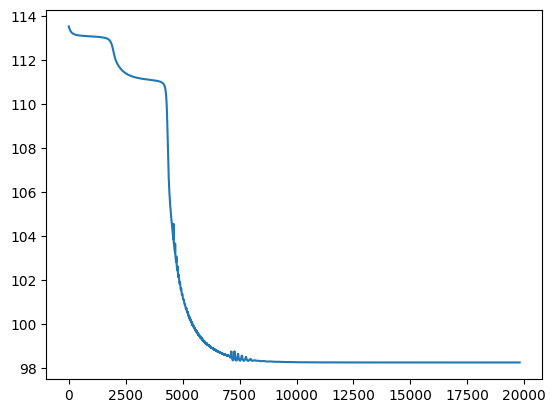

In [11]:
# Fit mode
w_hat_tobit, lengthscale_tobit, noise_tobit = fit_tobit_model()

# Laplace approximation to posterior
phi = features(x[:,None], lengthscale_tobit)
H_tobit = fit_laplace_posterior(w_hat_tobit,
                                lambda w: bayesian_censored_model_loss(w, phi, y, noise_tobit, MAX_VALUE=MAX_VALUE))


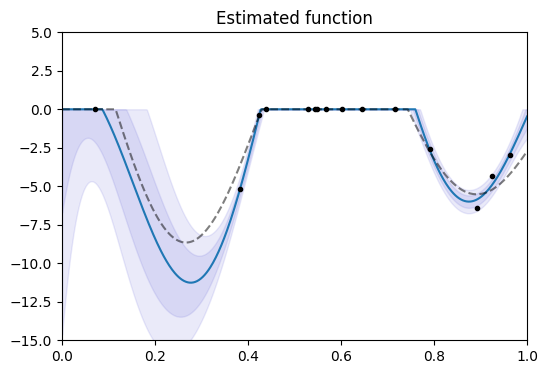

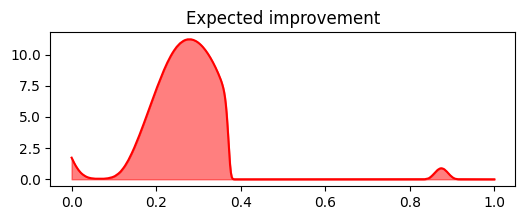

In [12]:
plot_result(w_hat_tobit, H_tobit, lengthscale_tobit, noise_tobit, censored=True)

## Pyro Implementation

In [62]:
!pip install -q pyro-ppl

In [ ]:
# # set path for importing scripts
# import sys
# sys.path.append('<path to the file where is stored 'censored_regressors' github repo >')

In [70]:
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import TraceMeanField_ELBO
from pyro.nn.module import PyroParam, pyro_method
from pyro.contrib.gp.util import conditional

import tqdm

from src import censored_normal
from src import likelihoods as pyro_custom_likelihood
from src import variational_gp as var_gp

In [71]:
# define kernel for the GP
pyro.clear_param_store()

kernel = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(5.),
    lengthscale=torch.tensor(0.05))

likelihood_ = pyro_custom_likelihood.CensoredHomoscedGaussian(low=-100., high=0.)

vgp = var_gp.VariationalGP(x, y, kernel, likelihood=likelihood_,  whiten=True, jitter=1e-02)

In [74]:
pyro.clear_param_store()

optimizer = torch.optim.Adam(vgp.parameters(), lr=0.01)
# optimizer = torch.optim.Adagrad(vgp.parameters(), lr=0.05)
# loss_fn = pyro.infer.TraceMeanField_ELBO().differentiable_loss
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss

pbar = tqdm.tqdm(range(20000), position=0, leave=True)

loss_ = []
for epoch in pbar:
  optimizer.zero_grad()
  loss = loss_fn(vgp.model, vgp.guide)
  loss.backward()
  optimizer.step()
  loss_.append(loss.item())

print("\nvariance = {: .6f}".format(vgp.kernel.variance))
print("lengthscale = {: .6f}".format(vgp.kernel.lengthscale))

  0%|          | 0/20000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:303: UserWarning: <class 'src.censored_normal.PyroCensoredNormal'> does not define `support` to enable sample validation. Please initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
100%|██████████| 20000/20000 [03:04<00:00, 108.13it/s]


variance =  13.112362
lengthscale =  0.069086


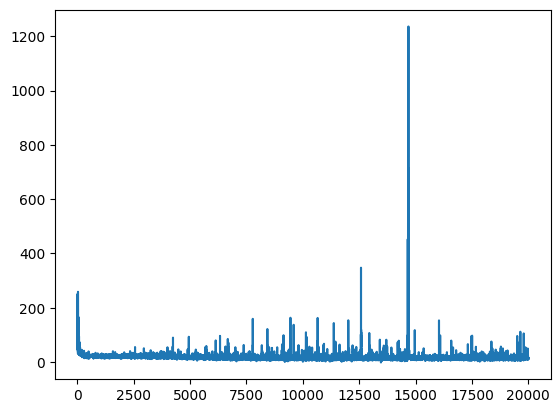

In [75]:
plt.plot(loss_)

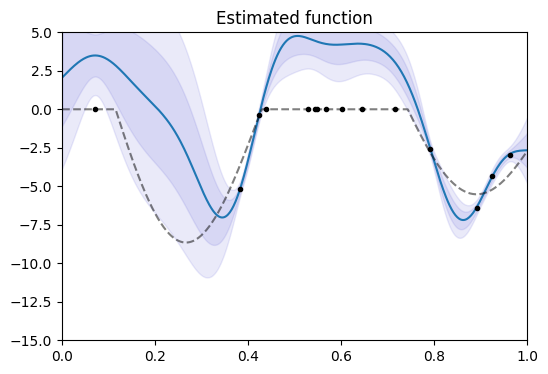

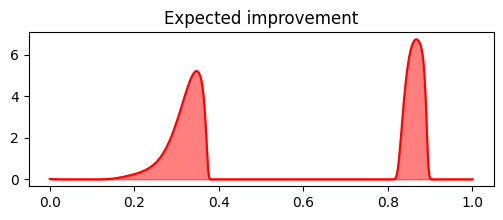

In [76]:
censored=False
N_samples = 1000
#     pred_samples = pred.sample((N_samples,)) + dist.Normal(0, noise).sample((N_samples,domain.shape[0]))

breakpoints = torch.linspace(0, 1, N_samples+1)[:-1]
breakpoints = breakpoints + breakpoints[1] * torch.rand_like(breakpoints)
with torch.no_grad():
  mean, cov = vgp.forward(torch.Tensor(domain), full_cov=True)
pred_samples = torch.distributions.Normal(mean, cov.diag().sqrt()).icdf(breakpoints[:,None])

if censored:
    c_pred = pred_samples > MAX_VALUE
    pred_samples[c_pred] = MAX_VALUE

pred_median = np.median(pred_samples, axis=0)
pred_quantiles = np.quantile(pred_samples, [0.025, 0.15, 0.85, 0.975], axis=0)

plt.figure(figsize=(6, 4))
plt.plot(domain, pred_median)

plt.fill_between(domain, pred_quantiles[0], pred_quantiles[-1], alpha=0.1, color='#33c');
plt.fill_between(domain, pred_quantiles[1], pred_quantiles[-2], alpha=0.1, color='#33c');

plt.plot(x, y, 'k.');
plt.plot(domain, noise_free_target(domain).clamp_max(MAX_VALUE), 'k--', alpha=0.5);
plt.xlim(0, 1);
plt.ylim(-15, 5);
plt.title("Estimated function")

plt.figure(figsize=(6, 2))
plt.title("Expected improvement")
EI =  -(pred_samples*(pred_samples < y.min()).float()).mean(0)
plt.plot(domain, EI, 'r');
plt.fill_between(domain, torch.zeros_like(domain), EI, color='r', alpha=0.5);